Загрузка pcap файлов...
Извлечение признаков...


C:\Users\Slyexistence\AppData\Local\Temp\ipykernel_14856\2492413103.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Метка'], palette='viridis')


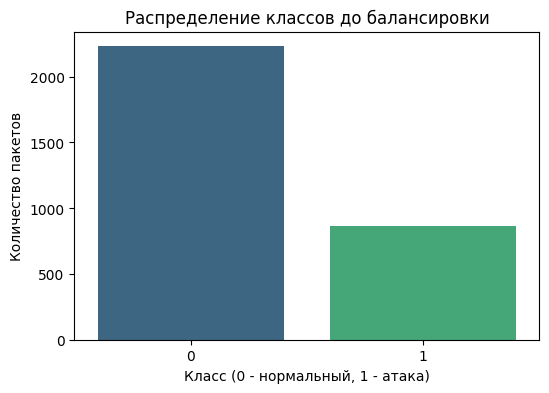

TypeError: can only concatenate str (not "float") to str

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import rdpcap, ARP
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. Загрузка данных ---
print("Загрузка pcap файлов...")
Normal_traffic = rdpcap(r'D:\Проекты\Дипломаня работа\DoFitN\Data\arp_N.pcapng')
Anomal_traffic = rdpcap(r'D:\Проекты\Дипломаня работа\DoFitN\Data\arp_A.pcapng')

# --- 2. Функция для извлечения признаков ---
def extract_pkt(arp_packets, label):
    data = []
    for pkt in arp_packets:
        if ARP in pkt:
            data.append([
                pkt.time,
                pkt[ARP].psrc,
                pkt[ARP].pdst,
                pkt[ARP].hwsrc,
                pkt[ARP].hwdst,
                pkt[ARP].op,
                label
            ])
    return data

print("Извлечение признаков...")
normal_arp = extract_pkt(Normal_traffic, label=0)
anomal_arp = extract_pkt(Anomal_traffic, label=1)

# --- 3. Создание DataFrame ---
columns = ['Time', 'IP источника', 'IP назначения', 'MAC источника', 'MAC назначения', 'Тип запроса', 'Метка']
df_normal = pd.DataFrame(normal_arp, columns=columns)
df_anomal = pd.DataFrame(anomal_arp, columns=columns)

df = pd.concat([df_normal, df_anomal], ignore_index=True)

# --- 4. Проверка баланса классов ---
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Метка'], palette='viridis')
plt.title("Распределение классов до балансировки")
plt.xlabel("Класс (0 - нормальный, 1 - атака)")
plt.ylabel("Количество пакетов")
plt.show()


# --- 5. Аугментация данных (если данных мало) ---
def augment_data(df, noise_factor=0.01):
    # Делаем копию данных, исключая категориальные столбцы
    df_numeric = df[['Time', 'IP источника', 'IP назначения', 'MAC источника', 'MAC назначения', 'Тип запроса']]
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=df_numeric.shape)
    df_aug = df.copy()
    df_aug[['Time', 'IP источника', 'IP назначения', 'MAC источника', 'MAC назначения', 'Тип запроса']] += noise
    return df_aug

# Переходим к нормализации и балансировке


if len(df_normal) < 5000:  # Применяем аугментацию, если данных < 5000
    df_normal = pd.concat([df_normal, augment_data(df_normal)])

# --- 6. Балансировка классов (если аномалий мало) ---
if len(df_normal) > len(df_anomal):
    df_anomal = resample(df_anomal, replace=True, n_samples=len(df_normal), random_state=42)

df = pd.concat([df_normal, df_anomal])

plt.figure(figsize=(6, 4))
sns.countplot(x=df['Метка'], palette='coolwarm')
plt.title("Распределение классов после балансировки")
plt.xlabel("Класс (0 - нормальный, 1 - атака)")
plt.ylabel("Количество пакетов")
plt.show()

# --- 7. Кодирование категориальных данных ---
print("Кодирование IP и MAC адресов...")
le_ip = LabelEncoder()
le_mac = LabelEncoder()

le_ip.fit(df['IP источника'].tolist() + df['IP назначения'].tolist())
df['IP источника'] = le_ip.transform(df['IP источника'])
df['IP назначения'] = le_ip.transform(df['IP назначения'])

le_mac.fit(df['MAC источника'].tolist() + df['MAC назначения'].tolist())
df['MAC источника'] = le_mac.transform(df['MAC источника'])
df['MAC назначения'] = le_mac.transform(df['MAC назначения'])

# --- 8. Нормализация ---
print("Нормализация данных...")
scaler = MinMaxScaler()
df[['Time', 'IP источника', 'IP назначения', 'MAC источника', 'MAC назначения']] = scaler.fit_transform(
    df[['Time', 'IP источника', 'IP назначения', 'MAC источника', 'MAC назначения']]
)

# --- 9. Подготовка данных для LSTM ---
def create_sequences(data, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length])
    return np.array(sequences), np.array(seq_labels)

seq_length = 10  # Длина последовательности

X = df[['Time', 'IP источника', 'IP назначения', 'MAC источника', 'MAC назначения', 'Тип запроса']].values
y = df['Метка'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

# --- 10. Создание модели LSTM с Dropout ---
print("Создание модели LSTM...")
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])),
    Dropout(0.2),  # Dropout для предотвращения переобучения
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 11. Обучение модели ---
print("Обучение модели...")
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.1)

# --- 12. Визуализация процесса обучения ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Эпохи")
plt.ylabel("Accuracy")
plt.title("График точности (Accuracy)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("График потерь (Loss)")
plt.legend()

plt.show()

# --- 13. Оценка модели ---
print("Оценка модели...")
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# --- 14. Применение модели ---
print("Применение модели...")
predictions = model.predict(X_test_seq)
predictions_binary = (predictions > 0.5).astype(int)

# --- 15. Матрица ошибок ---
conf_matrix = confusion_matrix(y_test_seq, predictions_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Норма", "Атака"], yticklabels=["Норма", "Атака"])
plt.xlabel("Предсказанные")
plt.ylabel("Истинные")
plt.title("Матрица ошибок")
plt.show()

# --- 16. ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test_seq, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()

print("Отчет о классификации:")
print(classification_report(y_test_seq, predictions_binary))
